In [1]:
# Import needed packages
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from statannotations.Annotator import Annotator

import my_functions as my_func
from phFCD import *
from petTOAD_setup import *
from integration import IntegrationFromFC_Fast
from segregation import computeSegregation


# Directories
SPINE = Path.cwd().parents[2]
DATA_DIR = SPINE / "data"
PREP_DIR = DATA_DIR / "preprocessed"
FPRP_DIR = PREP_DIR / "fmriprep"
UTL_DIR = DATA_DIR / "utils"
WMH_DIR = PREP_DIR / "WMH_segmentation"
XCP_DIR = PREP_DIR / "xcp_d"

REL_SES = "M00"

RES_DIR = SPINE / "results"
FIG_DIR = RES_DIR / "figures"
LQT_DIR = RES_DIR / "LQT"
SIM_DIR = RES_DIR / "final_simulations"

Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


## Load functions

In [2]:
def load_df_arrays(groupname, model):
    df_group = pd.read_csv(SIM_DIR / groupname / f"df_results_{groupname}_{model}.csv", index_col=[0], header=[0])
    if groupname == "CN_no_WMH":
        arr_fc_phfcd = np.load(SIM_DIR / groupname / f"group-{groupname}-results-fc_phfcd_model-{model}.npz")
    else:
        arr_fc_phfcd = np.load(SIM_DIR / groupname / f"group-{groupname}_results-fc_phfcd_model-{model}.npz")
    return df_group, arr_fc_phfcd


def create_pivot_tables(df_res):
    # Convert the result df into a pivot table so to plot heatmap
    table_fc = pd.pivot_table(
        df_res, values="fc_pearson", index="b", columns="w"
    ).astype(float)
    # Skip fcd for now
    # table_fcd = pd.pivot_table(res_df, values='fcd_ks', index='b', columns='w').astype(float)
    table_phfcd = pd.pivot_table(
        df_res, values="phfcd_ks", index="b", columns="w"
    ).astype(float)
    # Create a composite score by summing up the single model fits so to choose when FC and phFCD have different "best" b-w combinations
    table_comp_score = table_fc + 2 * table_phfcd
    return table_fc, table_phfcd, table_comp_score

def annotate_star(tbl):
    """
    This function is just to plot an asterisk at the best heatmap value for better recognition.
    """
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): "*"})
    return star

def plot_save_heatmaps(table_fc, table_phfcd, table_comp_score, random):
    """
    This function starts from the results dataframe, converts it into a pivot-table, which is what seaborn need to plot the heatmap.
    It does so both for fc and for phfcd. Also plots and saves the results.
    """
    # Create Heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ax=axs[0],
        data=table_fc,
        annot=annotate_star(table_fc),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[0].set_title(f"FC", fontsize=9)

    sns.heatmap(
        ax=axs[1],
        data=table_phfcd,
        annot=annotate_star(table_phfcd),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[1].set_title(f"1 - phFCD", fontsize=9)
    sns.heatmap(
        ax=axs[2],
        data=table_comp_score,
        annot=annotate_star(table_comp_score),
        fmt="",
        annot_kws={"size": 10},
    )
    axs[2].set_title(f"GFS", fontsize=9)
    if not random:
        savename = f"weights_and_bias_heatmap.png"
        fig.suptitle("Random = False")
    else:
        savename = f"weights_and_bias_heatmap_random.png"
        fig.suptitle("Random = True")
    fig.tight_layout()
    #plt.savefig(FIG_DIR / savename)

def get_group_empirical_observables(groupname, grouplist):
    print(f"Calculating the group empirical phfcd for {groupname}...")
    dict_group = {subj: all_fMRI_clean[subj] for subj in grouplist}
    empirical_fc = np.array([my_func.fc(ts) for ts in dict_group.values()])
    empirical_phfcd = np.array([phFCD(ts) for ts in dict_group.values()])
    return empirical_fc, empirical_phfcd

def save_annotator_results_raw(groupname, results, comparing_what):
    dict_res = {}
    for res in results:
        dict_key = res.data.group1 + "_" + res.data.group2
        dict_res[dict_key] = res.data.formatted_output.split(",")[1]
    test_name = res.data.formatted_output.split(",")[0]
    df = pd.DataFrame(dict_res, index = [test_name]).T
    df.to_csv(SIM_DIR / f"group-{groupname}_df_{comparing_what}_desc-comparison.csv")

## Functions for Monte-carlo phfcd calculations

In [3]:
def phfcd_parallel_iteration(n_repeats, emp_phfcd, sim_phfcd, n_random_samples):
    # np.random.seed(np.random.RandomState().randint(1))
    random_sample_indices_emp = np.random.RandomState().choice(emp_phfcd.shape[0], n_random_samples, replace=False)
    emp_phfcd_array_random_sample = emp_phfcd[random_sample_indices_emp].flatten()
    sim_random_sample_indices = np.random.RandomState().choice(sim_phfcd.shape[0], n_random_samples, replace=False)
    sim_phfcd_array_random_sample = sim_phfcd[sim_random_sample_indices]
    phfcd_ks = [my_func.matrix_kolmogorov(sim_phfcd_array_random_sample[:, n].flatten(), emp_phfcd_array_random_sample) for n in range(sim_phfcd_array_random_sample.shape[1])]
    return phfcd_ks

def montecarlo_phfcd_parallel(emp_phfcd, sim_phfcd, n_samples=25, repeats=5):
    """
    This function performs Montecarlo simulations to evaluate the difference between empirical and simulated phase functional connectivity dynamics in parallel.
    
    Args:
        emp_phfcd (arr): the array with all the phase functional connectivity dynamics for the empirical data from patient in the specific group
        sim_phfcd (arr): the array with all the phase functional connectivity dynamics for the simulated data in the group
        n_samples (int): the number of individuals you want in your sub-sample for each iteration (default = 25)
        repeats (int): the number of times you want to repeat the simulations (default = 5 for testing)
        n_workers (int): the number of parallel workers to use (default is None, which means using the maximum available)
    
    Returns:
        arr_results_ksd (arr): an array with the Kolmogorov-Smirnov distance between the cumulative distribution of the empirical and simulated data
                               out of the n_samples subjects.

    """
    n_repeats = range(repeats)
    with ProcessPoolExecutor(max_workers=350) as executor:
        results = list(executor.map(partial(phfcd_parallel_iteration, emp_phfcd=emp_phfcd, sim_phfcd=sim_phfcd, n_random_samples=n_samples), n_repeats))
    arr_results_ksd = np.array(results)
    return arr_results_ksd

def run_montecarlo_phfcd(groupname, model, empirical_phfcd, n_repeats):
    df, arr_fc_phfcd = load_df_arrays(groupname, model)
    simulated_phfcd = arr_fc_phfcd["phfcd"]
    print(f"Now performing Montecarlo simulations of KSD between empirical and simulated data for {groupname} {model}...")
    start_time = time.time()
    arr_res = montecarlo_phfcd_parallel(empirical_phfcd, simulated_phfcd, n_samples=25, repeats=n_repeats) #working ~3 minutes for 100 simulations
    end_time = time.time()
    print(f"Done performing Montecarlo for {groupname} {model}! It took {round(end_time - start_time, 3)} seconds")
    return df, arr_res

def plot_model_comparison(groupname, df, obs, ax):
    """
    This function plots the annotations for statistical comparisons between groups
    """
    order = ["Base", "Homog. a", "Heterog. a", "Homog. G"]
    # Choose the combinations that you want to test..
    pairs = [
        ("Base", "Homog. a"),
        ("Base", "Heterog. a"),
        ("Base", "Homog. G"),
        #("Base", "Disconn."),
        ("Homog. a", "Heterog. a"),
        ("Homog. a", "Homog. G"),
        ("Heterog. a", "Homog. G"),
    ]
    f = sns.boxplot(data=df, x="model", y=obs, ax=ax, order = order)
    annotator = Annotator(f, pairs, data=df, x="model", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=1)
    annotator.configure(comparisons_correction="Bonferroni", verbose=2)
    _, results = annotator.apply_and_annotate()
    plt.xticks([0, 1, 2, 3], order)
    save_annotator_results_raw(groupname, results, "models")    


def plot_and_save_both_groups_model_comparison(df_cn_wmh, df_mci_wmh):
    # Make the final plot to compare different models in CU WMH and MCI WMH
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
    plot_model_comparison("CN_WMH", df_cn_wmh, "phfcd_ks", axs[0])
    plot_model_comparison("MCI_WMH", df_mci_wmh, "phfcd_ks", axs[1])
    axs[0].set_ylabel("KSD")
    axs[0].set_xlabel("Model type")
    axs[0].set_title("CU WMH")
    axs[1].set_ylabel("KSD")
    axs[1].set_xlabel("Model type")
    axs[1].set_title("MCI WMH")
    fig.tight_layout()
    fig.savefig(FIG_DIR / "boxplots_with_comparisons_of_all_models_in_the_two_subgroups_with_wmh.png")


def run_montecarlo_model_comparisons(groupname, grouplist, n_rep, no_wmh_best_a=None):
    _, emp_phfcd = get_group_empirical_observables(groupname, grouplist)
    df_a, arr_phfcd_ks_a = run_montecarlo_phfcd(groupname, "homogeneous_a", emp_phfcd, n_repeats = n_rep)
    df_a["a"] = [float(df_a["a"][i].split(" ")[1]) for i in range(len(df_a["a"]))]
    df_G, arr_phfcd_ks_G = run_montecarlo_phfcd(groupname, "homogeneous_G", emp_phfcd, n_repeats = n_rep)
    df_het, arr_phfcd_ks_het = run_montecarlo_phfcd(groupname, "heterogeneous", emp_phfcd, n_repeats = n_rep)
    df_disconn, arr_phfcd_ks_disconn = run_montecarlo_phfcd(groupname, "disconn", emp_phfcd, n_repeats = n_rep)

    data_to_save = {
    "a": arr_phfcd_ks_a,
    "G": arr_phfcd_ks_G,
    "het": arr_phfcd_ks_het,
    "disconn": arr_phfcd_ks_disconn
    }

    np.savez_compressed(SIM_DIR / groupname / f"group-{groupname}_models-all_data-empirical_simulated-desc-ksd-montecarlo-{n_rep}-repeats.npz", **data_to_save)

    # When modeling CN with WMH, the last value of the homogeneous_a model represents the best a found in the CN no WMH group by definition because we start from there
    # and we move toward more negative values (since we have negative values, the first simulated will be the most negative and then we move on to the ones closer to 0).
    # So if we want to see how the baseline model (the best one fitted on CN without WMH) performs in CN WMH, the index is the last one.
    if groupname == "CN_WMH":
        base_idx = arr_phfcd_ks_a.shape[1] - 1 
    # When modeling MCI with WMH it is a bit different, because we start our range of explorations still with the best a found in CN without WMH, but this might not be 
    # the best in MCI without WMH (and we want to compare MCI with to MCI without WMH). So no_wmh_best_a represents the best a that is found in MCI without WMH, then we
    # get the corresponding index from the df (and this will be the same as the best index in the phfcd array)
    else:
        base_idx = df_a[df_a["a"] == no_wmh_best_a].index.values[0]

    best_idx_a = arr_phfcd_ks_a.mean(axis=0).argmin() # Get the a where the mean phfcd is the best
    best_idx_G = arr_phfcd_ks_G.mean(axis=0).argmin() # Get the G where the mean phfcd is the best
    best_idx_het = arr_phfcd_ks_het.mean(axis=0).argmin() # Get the hetero where the mean phfcd is the best

    dict_best_values = {groupname: {"homogeneous_a": df_a["a"][best_idx_a],
                                    "homogeneous_G": df_G["K_gl"][best_idx_G],
                                    "heterogeneous": {"b": df_het.iloc[best_idx_het]["b"], "w": df_het.iloc[best_idx_het]["w"]}}}
    with open(SIM_DIR / groupname / f"group-{groupname}_dict-best_values_mdoels-all.json", "w") as outfile: 
        json.dump(dict_best_values, outfile)

    base_box = arr_phfcd_ks_a[:, base_idx] # Only get the distribution of values at the best index for the specific model for plotting as boxplots
    best_a_box = arr_phfcd_ks_a[:, best_idx_a]
    best_G_box = arr_phfcd_ks_G[:, best_idx_G]
    #best_disconn_box = arr_phfcd_ks_mci_wmh_disconn #so far totally out
    best_het_box = arr_phfcd_ks_het[:, best_idx_het]
    df_compare_boxplot = pd.DataFrame({"Base": base_box,
                                    "Homog. a": best_a_box,
                                    "Homog. G": best_G_box,
                                    "Heterog. a": best_het_box})
    df_compare_boxplot_melted = df_compare_boxplot.melt().rename(columns={'variable': 'model', 'value': 'phfcd_ks'})
    df_compare_boxplot_melted.to_csv(SIM_DIR / groupname / f"group-{groupname}_df_to_compare_all_models_with_boxplots.csv")
    return df_compare_boxplot_melted, best_idx_a, best_idx_G, best_idx_het # remember to add best_disconn_box when done

## Functions for Monte-Carlo for empirical integration and segregation

In [4]:
def integration_parallel(n_repeats: int, arr_fc: np.ndarray, n_random_samples: int):
    """
    Calculate integration from a subset of n_random_samples out of the whole array of functional connectivities for a group. To be used with run_int_seg_parallel()

    Parameters:
    - n_repeats (int): Number of Monte-Carlo runs to perform.
    - arr_fc (np.ndarray): 3D array of functional connectivity data for subjects in the chosen group.
    - n_random_samples (int): Number of subjects to randomly sample in each simulation.

    Returns:
    - integration: Integration measure
    """
    # Randomly sample n subjects
    random_sample_indices = np.random.RandomState().choice(arr_fc.shape[0], n_random_samples, replace=False)
    random_sample_data = arr_fc[random_sample_indices]
    # Calculate average connectivity for the random sample
    average_connectivity = np.abs(random_sample_data.mean(axis=0))
    integration = IntegrationFromFC_Fast(average_connectivity)
    return integration

def segregation_parallel(n_repeats: int, arr_fc: np.ndarray, n_random_samples: int):
    """
    Calculate segregation from a subset of n_random_samples out of the whole array of functional connectivities for a group. To be used with run_int_seg_parallel()

    Parameters:
    - n_repeats (int): Number of Monte Carlo simulations to perform.
    - arr_fc (np.ndarray): 3D array of functional connectivity data for subjects.
    - n_random_samples (int): Number of subjects to randomly sample in each simulation.

    Returns:
    - segregation (float): Segregation measure.  
    """
    # Randomly sample n subjects
    random_sample_indices = np.random.RandomState().choice(arr_fc.shape[0], n_random_samples, replace=False)
    random_sample_data = arr_fc[random_sample_indices]
    # Calculate average connectivity for the random sample
    average_connectivity = np.abs(random_sample_data.mean(axis=0))
    segregation = computeSegregation(average_connectivity)[0]
    return segregation

def run_int_seg_parallel(groupname: str, arr_fc: np.ndarray, repeats: int, n_samples: int = 25):
    """
    Run parallel Monte-Carlo simulations for integration and segregation.

    Parameters:
    - groupname (str): Name of the group for which simulations are performed.
    - arr_fc (np.ndarray): 3D array of functional connectivity data for subjects.
    - repeats (int): Number of Monte Carlo simulations to perform.
    - n_samples (int): Number of subjects to randomly sample in each simulation. Default is 25.

    Returns:
    - (integrations, segregations) (tuple): Tuple of lists containing integration and segregation measures.
    """

    print(f"Calculating Montecarlo simulations for integration and segregation for group {groupname} for {repeats} times...")
    n_repeats = range(repeats)
    with ProcessPoolExecutor(max_workers=350) as executor:
        integrations = list(executor.map(partial(integration_parallel, arr_fc = arr_fc, n_random_samples=n_samples), n_repeats))
        segregations = list(executor.map(partial(segregation_parallel, arr_fc = arr_fc, n_random_samples=n_samples), n_repeats))
    return integrations, segregations

def plot_int_or_seg(df: pd.DataFrame, obs: str, ax: plt.Axes):
    """
    Plot boxplots for integration or segregation measures with statistical comparisons among Fazekas groups

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data for plotting.
    - obs (str): Name of the observation variable (e.g., "Integration" or "Segregation").
    - ax (plt.Axes): Matplotlib Axes object to draw the plot onto.

    Returns:
    - None
    """
    order = ["CN_no_WMH", "CN_WMH", "MCI_no_WMH", "MCI_WMH"]
    # Choose the combinations that you want to test..
    pairs = [
        ("CN_no_WMH", "CN_WMH"),
        ("MCI_no_WMH", "MCI_WMH"),
    ]
    f = sns.boxplot(data=df, x="Fazekas group", y=obs, ax=ax, order = order)
    annotator = Annotator(f, pairs, data=df, x="Fazekas group", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=1)
    _, results = annotator.apply_and_annotate()
    ax.set_xticks([0, 1, 2, 3], order)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(["CU no WMH", "CU WMH", "MCI no WMH", "MCI WMH"])
    save_annotator_results_raw("all", results, obs)

def plot_int_seg_comparison(df_int: pd.DataFrame, df_seg: pd.DataFrame):
    """
    Plot side-by-side boxplots for integration and segregation measures.

    Parameters:
    - df_int (pd.DataFrame): DataFrame containing integration data.
    - df_seg (pd.DataFrame): DataFrame containing segregation data.

    Returns:
    - None
    """
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
    print("#######################################################################")
    print("Integration")
    print("#######################################################################")
    plot_int_or_seg(df_int, "Integration", axs[0])
    print("#######################################################################")
    print("Segregation")
    print("#######################################################################")
    plot_int_or_seg(df_seg, "Segregation", axs[1])
    fig.tight_layout()
    fig.savefig(FIG_DIR / "boxplot_compare_integration_segregation_empirical_no-wmh_vs_wmh.png")

def create_and_save_int_seg_df(integrations, segregations, n_repeats):
    """
    Create DataFrames from integration and segregation results and save them to CSV files.

    Parameters:
    - integrations (Dict[str, List[float]]): Dictionary containing integration results for different groups.
    - segregations (Dict[str, List[float]]): Dictionary containing segregation results for different groups.

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]: DataFrames containing integration and segregation data.
    """
    df_int = pd.DataFrame(integrations).melt(var_name='Fazekas group', value_name='Integration')
    df_seg = pd.DataFrame(segregations).melt(var_name='Fazekas group', value_name='Segregation')
    df_int.to_csv(SIM_DIR /  f"group-all_data-empirical_df-integration_desc-montecarlo-{n_repeats}-repeats.csv")
    df_seg.to_csv(SIM_DIR / f"group-all_data-empirical_df-segregation_desc-montecarlo-{n_repeats}-repeats.csv")
    return df_int, df_seg

def run_montecarlo_int_seg_empirical(n_rep: int):
    """
    Run Monte-Carlo simulations for integration and segregation for different groups, save results, and plot comparisons.

    Parameters:
    - n_repeats (int): Number of Monte Carlo simulations to perform.

    Returns:
    - None
    """
    dict_groups = {'CN_no_WMH': CN_no_WMH, 'CN_WMH': CN_WMH, 'MCI_no_WMH': MCI_no_WMH, 'MCI_WMH': MCI_WMH}
    integrations = {}
    segregations = {}
    for groupname, grouplist in dict_groups.items():
        group_emp_fc, _ = get_group_empirical_observables(groupname, grouplist)
        integrations[groupname], segregations[groupname] = run_int_seg_parallel(groupname, group_emp_fc, repeats = n_rep)
    df_int, df_seg = create_and_save_int_seg_df(integrations, segregations, n_rep)
    plot_int_seg_comparison(df_int, df_seg)


In [5]:
def plot_save_cn_no_wmh():
    df_cn_no_wmh_G, _ = load_df_arrays("CN_no_WMH", "homogeneous_G")
    best_G_idx = df_cn_no_wmh_G['phfcd_ks'].argmin()
    best_G = df_cn_no_wmh_G["K_gl"][best_G_idx]
    plt.figure()
    plt.plot(df_cn_no_wmh_G["K_gl"], df_cn_no_wmh_G["fc_pearson"], label = "FC")
    plt.plot(df_cn_no_wmh_G["K_gl"], df_cn_no_wmh_G["phfcd_ks"], label = "phFCD")
    plt.xlabel("Global coupling (G)")
    plt.ylabel("PCC/KSD")
    plt.title("Finding best G in CU without WMH")
    plt.text(1.2, 0.7, f"Best G for CU without WMH found at {best_G}")
    plt.savefig(FIG_DIR / "best_G_CU_no_WMH.png")
    return best_G, best_G_idx

def plot_save_mci_no_wmh():
    df_mci_no_wmh_a, _ = load_df_arrays("MCI_no_WMH", "homogeneous_a")
    list_values_a = [float(df_mci_no_wmh_a["a"][i].split(" ")[1]) for i in range(len(df_mci_no_wmh_a["a"]))]
    best_a_idx = df_mci_no_wmh_a['phfcd_ks'].argmin()
    best_a = list_values_a[best_a_idx]
    plt.figure()
    plt.plot(list_values_a, df_mci_no_wmh_a["fc_pearson"], label = "FC")
    plt.plot(list_values_a, df_mci_no_wmh_a["phfcd_ks"], label = "phFCD")
    plt.xlabel("Bifurcation parameters")
    plt.ylabel("PCC/KSD")
    plt.text(-0.1, 0.1, f"Best a for MCI without WMH found at {best_a}")
    plt.title("Finding best a in MCI without WMH")
    plt.savefig(FIG_DIR / "best_a_MCI_no_WMH.png")
    return best_a, best_a_idx

In [15]:
def prepare_df_for_plotting_int_seg(dict_int_or_seg, obs_name, n_simulations):
    df = pd.DataFrame.from_dict(dict_int_or_seg)
    df["CN_no_WMH"]["homogeneous_a"] = np.repeat(np.nan, n_simulations)
    df["CN_no_WMH"]["heterogeneous"] = np.repeat(np.nan, n_simulations)
    df["MCI_no_WMH"]["heterogeneous"] = np.repeat(np.nan, n_simulations)
    df["MCI_no_WMH"]["homogeneous_G"] = np.repeat(np.nan, n_simulations)
    df_exploded = df.explode(["CN_no_WMH", "MCI_no_WMH", "CN_WMH", "MCI_WMH"])
    df_long = pd.melt(df_exploded.reset_index(), id_vars=['index'], var_name='group', value_name=obs_name).dropna()
    df_long = df_long.rename(columns={"index": "model_type"})
    df_long["group_model"] = df_long["group"] + "_" + df_long["model_type"]
    df_long[obs_name] = df_long[obs_name].astype(float) # needs to reconvert to float otherwise statannotations complains
    return df_long


def plot_int_seg_comparison_simulated(df_long, wmh_models, obs_name, ax, model_type):
    baseline_models = ["CN_no_WMH_homogeneous_G", "MCI_no_WMH_homogeneous_a"]
    order = [baseline_models[0], wmh_models[0], baseline_models[1], wmh_models[1]]
    pairs = [
        (baseline_models[0], wmh_models[0]),
        (baseline_models[1], wmh_models[1])
        ]  
    df_long_boxplot = df_long[df_long["group_model"].isin(baseline_models + wmh_models)]
    b = sns.boxplot(data=df_long_boxplot, x = "group_model", y = obs_name, order = order, ax = ax)
    annotator = Annotator(b, pairs, data = df_long_boxplot, x = "group_model", y = obs_name, order = order)
    # Choose the type of statistical test to perform
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=1)
    _, results = annotator.apply_and_annotate()
    save_annotator_results_raw("all", results, "simulated_int_seg")    
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(["CU no WMH", "CU WMH", "MCI no WMH", "MCI WMH"])
    ax.set_xlabel("Fazekas group")
    save_annotator_results_raw("all", results, f"simulated_{obs_name}_{model_type}")
    

def _get_share_ax(share_var, axarr, row, col):
    "From: https://wil.yegelwel.com/subplots-with-row-titles/"
    if share_var=='row':
        if col > 0:
            return axarr[row, col-1]
        return None
    elif share_var=='col':
        if row > 0:
            return axarr[row-1, col]
        return None
    elif share_var and (col>0 or row>0):
        return axarr[0,0]
    return None

def subplots_with_row_titles(nrows, ncols, row_titles=None, row_title_kw=None, sharex=False, sharey=False, subplot_kw=None, grid_spec_kw=None, **fig_kw):
    """
    Creates a figure and array of axes with a title for each row.
    From: https://wil.yegelwel.com/subplots-with-row-titles/
    Parameters
    ----------
    nrows, ncols : int
        Number of rows/columns of the subplot grid
    row_titles : list, optional
        List of titles for each row. If included, there must be one title for each row.
    row_title_kw: dict, optional
        Dict with kewords passed to the `~matplotlib.Axis.set_title` function.
        A common use is row_title_kw={'fontsize': 24}
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (*sharex*) or y (*sharey*)
        axes:

        - True or 'all': x- or y-axis will be shared among all subplots.
        - False or 'none': each subplot x- or y-axis will be independent.
        - 'row': each subplot row will share an x- or y-axis.
        - 'col': each subplot column will share an x- or y-axis.

        When subplots have a shared x-axis along a column, only the x tick
        labels of the bottom subplot are created. Similarly, when subplots
        have a shared y-axis along a row, only the y tick labels of the first
        column subplot are created. To later turn other subplots' ticklabels
        on, use `~matplotlib.axes.Axes.tick_params`.
    subplot_kw : dict, optional
        Dict with keywords passed to the
        `~matplotlib.figure.Figure.add_subplot` call used to create each
        subplot.
    gridspec_kw : dict, optional
        Dict with keywords passed to the `~matplotlib.gridspec.GridSpec`
        constructor used to create the grid the subplots are placed on.
    **fig_kw
        All additional keyword arguments are passed to the
        `.pyplot.figure` call.
    """
    if row_titles is not None and len(row_titles) != nrows:
        raise ValueError(f'If row_titles is specified, there must be one for each row. Got={row_titles}')
    if subplot_kw is None:
        subplot_kw = {}
    if row_title_kw is None:
        row_title_kw = {}
    if sharex not in {True, False, 'row', 'col'}:
        raise ValueError(f'sharex must be one of [True, False, "row", "col"]. Got={sharex}')
    if sharey not in {True, False, 'row', 'col'}:
        raise ValueError(f'sharey must be one of [True, False, "row", "col"]. Got={sharey}')
        
    fig, big_axes = plt.subplots(nrows, 1, **fig_kw)
    for (row, big_ax) in enumerate(big_axes):
        if row_titles is not None:
            big_ax.set_title(str(row_titles[row]), **row_title_kw)
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax._frameon = False
        
    axarr = np.empty((nrows, ncols), dtype='O')
    for row in range(nrows):
        for col in range(ncols):
            sharex_ax = _get_share_ax(sharex, axarr, row, col)
            sharey_ax = _get_share_ax(sharex, axarr, row, col)
    
            ax= fig.add_subplot(nrows, ncols, row*ncols+col+1,
                                sharex=sharex_ax, sharey=sharey_ax, **subplot_kw)
            axarr[row, col] = ax
    return fig, axarr       

def plot_all_int_seg_comparisons_simulated(df_int_long, df_seg_long):
    homogeneous_a_wmh_models = ["CN_WMH_homogeneous_a", "MCI_WMH_homogeneous_a"]
    homogeneous_G_wmh_models = ["CN_WMH_homogeneous_G", "MCI_WMH_homogeneous_G"]
    heterogeneous_wmh_models = ["CN_WMH_heterogeneous", "MCI_WMH_heterogeneous"]

    row_to_fn = ["Homogeneous a model", "Homogeneous G model", "Heterogeneous model"]
    fig, axs = subplots_with_row_titles(3, 2, figsize=(10, 12), 
                                      row_titles=[f for f in row_to_fn], 
                                      row_title_kw=dict(fontsize=12, pad=20, fontweight = "bold"),
                                      sharex=False)
    plot_int_seg_comparison_simulated(df_int_long, homogeneous_a_wmh_models, "Integration", axs[0, 0], "homogeneous_a")
    plot_int_seg_comparison_simulated(df_seg_long, homogeneous_a_wmh_models, "Segregation", axs[0, 1], "homogeneous_a")
    plot_int_seg_comparison_simulated(df_int_long, homogeneous_G_wmh_models, "Integration", axs[1, 0], "homogeneous_G")
    plot_int_seg_comparison_simulated(df_seg_long, homogeneous_G_wmh_models, "Segregation", axs[1, 1], "homogeneous_G")
    plot_int_seg_comparison_simulated(df_int_long, heterogeneous_wmh_models, "Integration", axs[2, 0], "heterogeneous")
    plot_int_seg_comparison_simulated(df_seg_long, heterogeneous_wmh_models, "Segregation", axs[2, 1], "heterogeneous")
    fig.tight_layout()
    fig.savefig(FIG_DIR / "group-all_models-all_desc-comparison-integration-segregation.png")



def run_montecarlo_int_seg_simulated(n_rep: int, 
                                     cn_no_wmh_G_idx: int,
                                     mci_no_wmh_a_idx: int,
                                     idx_a_cn_wmh: int,
                                     idx_G_cn_wmh: int, 
                                     idx_het_cn_wmh: int, 
                                     idx_a_mci_wmh: int, 
                                     idx_G_mci_wmh: int, 
                                     idx_het_mci_wmh: int):
    """
    Run Monte-Carlo simulations for integration and segregation for different groups of simulated data, save results, and plot comparisons.

    Parameters:
    - n_repeats (int): Number of Monte Carlo simulations to perform.

    Returns:
    - None
    """
    dict_groups = {'CN_no_WMH': ["homogeneous_G"],
                'MCI_no_WMH': ["homogeneous_a"],
                'CN_WMH': ["homogeneous_a", "homogeneous_G", "heterogeneous"],
                'MCI_WMH': ["homogeneous_a", "homogeneous_G", "heterogeneous"]}
        
    integrations = {}
    segregations = {}
    for groupname, list_model in dict_groups.items():
        integrations[groupname] = {}
        segregations[groupname] = {}
        for model in list_model:
            _, arr_fc_phfcd = load_df_arrays(groupname, model)
            group_sim_fc = arr_fc_phfcd["fc"]
            if groupname == "CN_no_WMH":
                group_sim_fc_best = group_sim_fc[:, cn_no_wmh_G_idx]
            elif groupname == "MCI_no_WMH":
                group_sim_fc_best = group_sim_fc[:, mci_no_wmh_a_idx]
            elif groupname == "CN_WMH":
                if model == "homogeneous_a":
                    group_sim_fc_best = group_sim_fc[:, idx_a_cn_wmh]
                if model == "homogeneous_G":
                    group_sim_fc_best = group_sim_fc[:, idx_G_cn_wmh]
                if model == "heterogeneous":
                    group_sim_fc_best = group_sim_fc[:, idx_het_cn_wmh]
            elif groupname == "MCI_WMH":
                if model == "homogeneous_a":
                    group_sim_fc_best = group_sim_fc[:, idx_a_mci_wmh]
                if model == "homogeneous_G":
                    group_sim_fc_best = group_sim_fc[:, idx_G_mci_wmh]
                if model == "heterogeneous":
                    group_sim_fc_best = group_sim_fc[:, idx_het_mci_wmh]
            integrations[groupname][model], segregations[groupname][model] = run_int_seg_parallel(groupname, group_sim_fc_best, repeats = n_rep)
    df_int_long = prepare_df_for_plotting_int_seg(integrations, "Integration", n_simulations = n_rep)
    df_seg_long = prepare_df_for_plotting_int_seg(segregations, "Segregation", n_simulations = n_rep)
    df_int_long.to_csv(SIM_DIR / f"group-all_data-simulated_df-integration_desc-montecarlo-{n_rep}-repeats.csv")
    df_seg_long.to_csv(SIM_DIR / f"group-all_data-simulated_df-segregation_desc-montecarlo-{n_rep}-repeats.csv")
    plot_all_int_seg_comparisons_simulated(df_int_long, df_seg_long)
    return df_int_long, df_seg_long

Calculating the group empirical phfcd for CN_WMH...
Now performing Montecarlo simulations of KSD between empirical and simulated data for CN_WMH homogeneous_a...
Done performing Montecarlo for CN_WMH homogeneous_a! It took 13.591 seconds
Now performing Montecarlo simulations of KSD between empirical and simulated data for CN_WMH homogeneous_G...
Done performing Montecarlo for CN_WMH homogeneous_G! It took 37.939 seconds
Now performing Montecarlo simulations of KSD between empirical and simulated data for CN_WMH heterogeneous...
Done performing Montecarlo for CN_WMH heterogeneous! It took 41.46 seconds
Now performing Montecarlo simulations of KSD between empirical and simulated data for CN_WMH disconn...
Done performing Montecarlo for CN_WMH disconn! It took 0.338 seconds
Calculating the group empirical phfcd for MCI_WMH...
Now performing Montecarlo simulations of KSD between empirical and simulated data for MCI_WMH homogeneous_a...
Done performing Montecarlo for MCI_WMH homogeneous_a! 

(       model_type       group  Integration               group_model
 0   homogeneous_G   CN_no_WMH     0.635333   CN_no_WMH_homogeneous_G
 1   homogeneous_G   CN_no_WMH     0.634222   CN_no_WMH_homogeneous_G
 8   homogeneous_a  MCI_no_WMH     0.630667  MCI_no_WMH_homogeneous_a
 9   homogeneous_a  MCI_no_WMH     0.630222  MCI_no_WMH_homogeneous_a
 12  homogeneous_G      CN_WMH     0.636000      CN_WMH_homogeneous_G
 13  homogeneous_G      CN_WMH     0.614222      CN_WMH_homogeneous_G
 14  homogeneous_a      CN_WMH     0.624000      CN_WMH_homogeneous_a
 15  homogeneous_a      CN_WMH     0.614667      CN_WMH_homogeneous_a
 16  heterogeneous      CN_WMH     0.616667      CN_WMH_heterogeneous
 17  heterogeneous      CN_WMH     0.618889      CN_WMH_heterogeneous
 18  homogeneous_G     MCI_WMH     0.606222     MCI_WMH_homogeneous_G
 19  homogeneous_G     MCI_WMH     0.613778     MCI_WMH_homogeneous_G
 20  homogeneous_a     MCI_WMH     0.597111     MCI_WMH_homogeneous_a
 21  homogeneous_a  

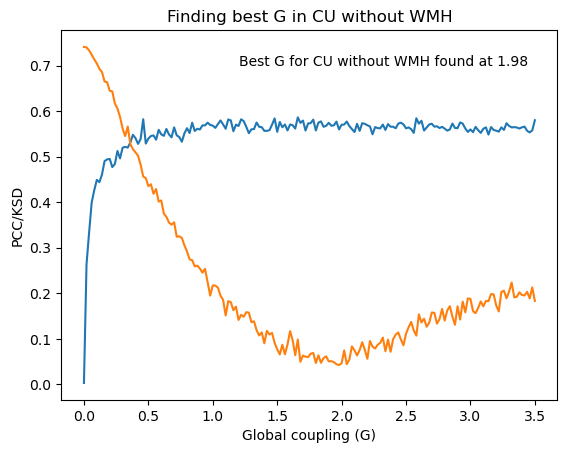

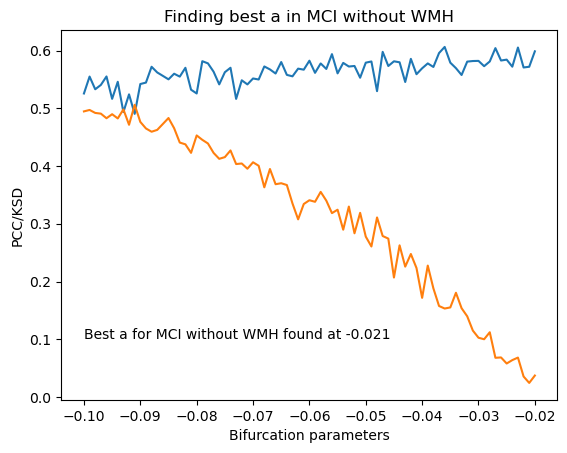

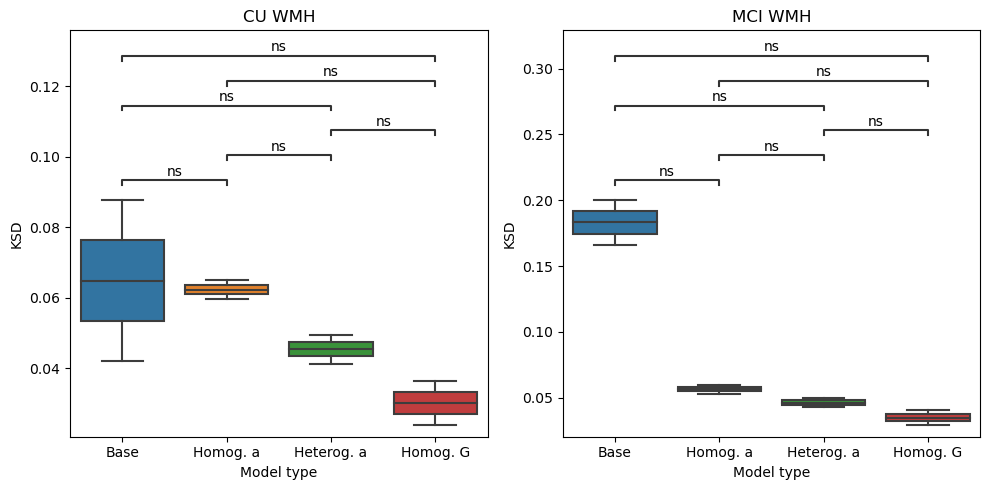

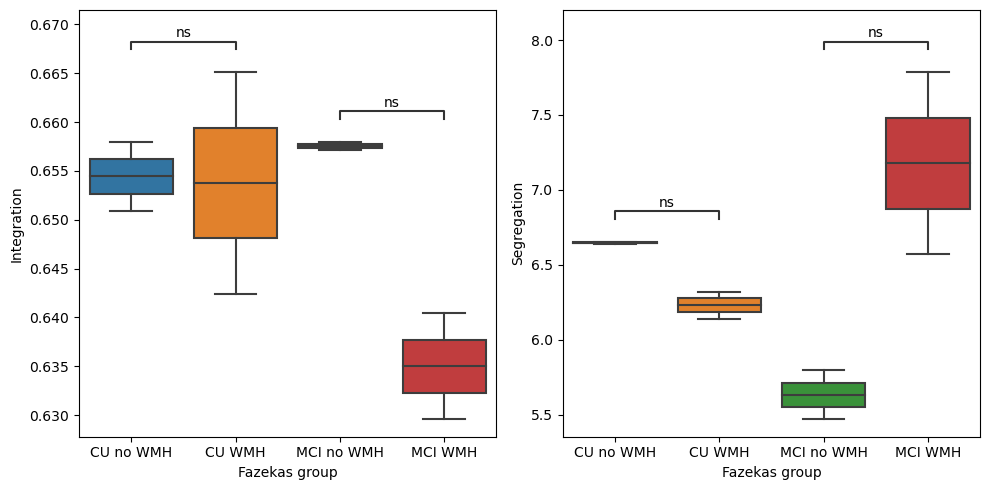

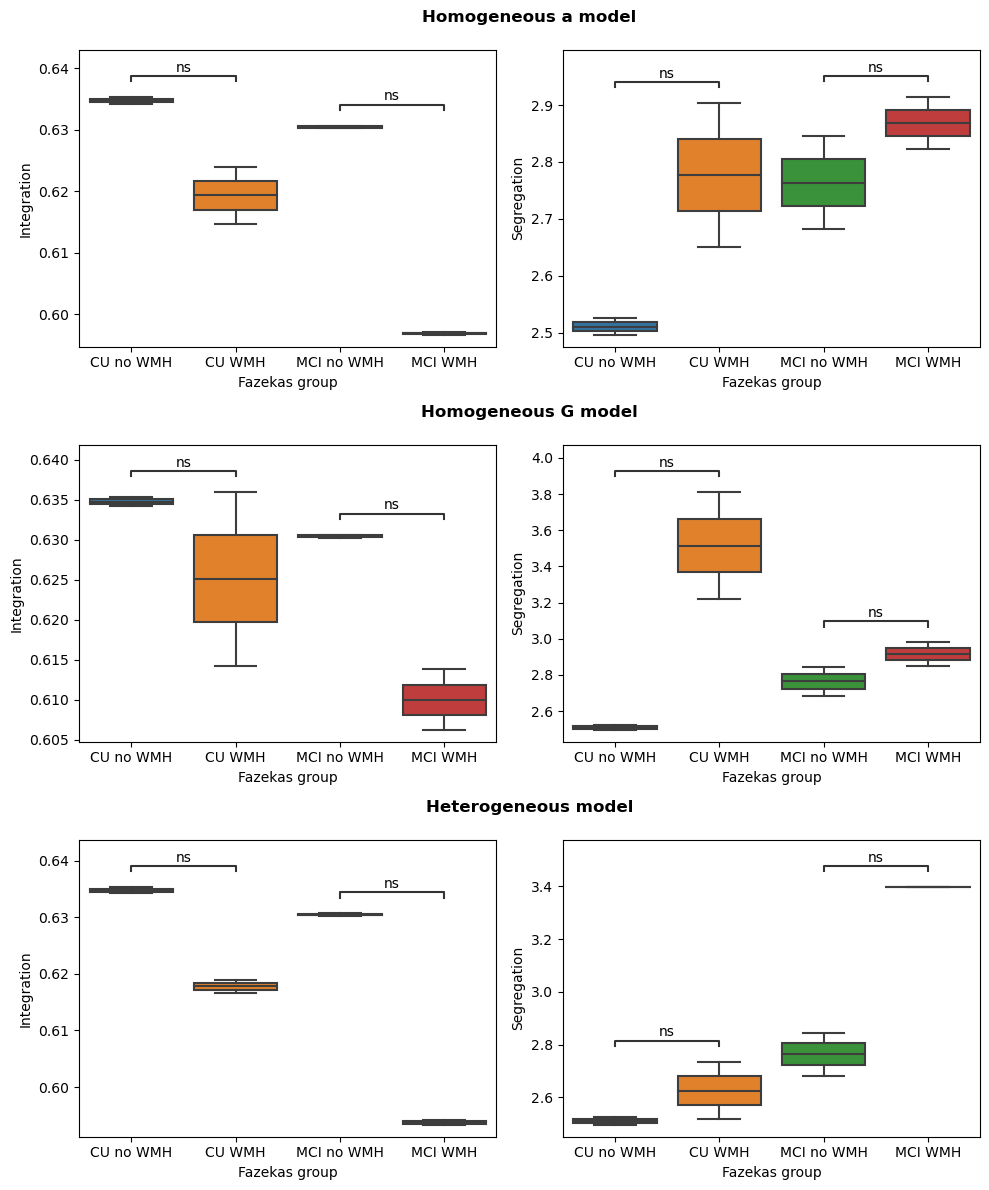

In [16]:
n_simulations = 2
cn_no_wmh_best_G, cn_no_wmh_best_G_idx = plot_save_cn_no_wmh()
mci_no_wmh_best_a, mci_no_wmh_best_a_idx = plot_save_mci_no_wmh()
df_all_models_cn_wmh, best_idx_a_cn_wmh, best_idx_G_cn_wmh, best_idx_het_cn_wmh = run_montecarlo_model_comparisons("CN_WMH", CN_WMH, n_rep = n_simulations)
df_all_models_mci_wmh, best_idx_a_mci_wmh, best_idx_G_mci_wmh, best_idx_het_mci_wmh = run_montecarlo_model_comparisons("MCI_WMH", MCI_WMH, n_rep = n_simulations, no_wmh_best_a = mci_no_wmh_best_a)
dict_best = {"cn_no_wmh_G_idx": cn_no_wmh_best_G_idx,
             "mci_no_wmh_a_idx": mci_no_wmh_best_a_idx,
             "idx_a_cn_wmh": best_idx_a_cn_wmh,
             "idx_G_cn_wmh": best_idx_G_cn_wmh,
             "idx_het_cn_wmh": best_idx_het_cn_wmh, 
             "idx_a_mci_wmh": best_idx_a_mci_wmh, 
             "idx_G_mci_wmh": best_idx_G_mci_wmh, 
             "idx_het_mci_wmh": best_idx_het_mci_wmh}

df_best = pd.DataFrame(dict_best, index = [0])
df_best.to_csv(SIM_DIR / "group-all_data-simulated_models-all_df-best_indices.csv")

plot_and_save_both_groups_model_comparison(df_all_models_cn_wmh, df_all_models_mci_wmh)
run_montecarlo_int_seg_empirical(n_rep = n_simulations)
run_montecarlo_int_seg_simulated(n_rep = n_simulations,
                                 cn_no_wmh_G_idx = cn_no_wmh_best_G_idx,
                                 mci_no_wmh_a_idx = mci_no_wmh_best_a_idx,
                                 idx_a_cn_wmh = best_idx_a_cn_wmh,
                                 idx_G_cn_wmh = best_idx_G_cn_wmh,
                                 idx_het_cn_wmh = best_idx_het_cn_wmh, 
                                 idx_a_mci_wmh = best_idx_a_mci_wmh, 
                                 idx_G_mci_wmh = best_idx_G_mci_wmh, 
                                 idx_het_mci_wmh = best_idx_het_mci_wmh)

# Other old code

In [8]:
# def perform_monte_carlo_phfcd(emp_phfcd, sim_phfcd, n_samples=25, repeats=5):
#     """
#     This function performs Montecarlo simulations to evaluate the difference between empirical and simulated phase functional connectivity dynamics.
    
#     Args:
#         emp_phfcd (arr): the array with all the phase functional connectivity dynamics for the empirical data from patient in the specific group
#         sim_phfcd (arr): the array with all the phase functional connectivity dynamics for the simulated data in the group
#         n_samples (int): the number of individuals you want in your sub-sample for each iteration (default = 25)
#         repeats (int): the number of times you want to repeat the simulations (default = 5 for testing)
    
#     Returns:
#         arr_results_ksd (arr): an array with the Kolmogorov-Smirnov distance between the cumulative distribution of the empirical and simulated data
#                                out of the n_samples subjects.

#     """
#     n_parms = sim_phfcd.shape[1]
#     n_random_samples = n_samples # similar to sample size in previous studies
#     n_repeats = repeats
#     arr_results_ksd = np.zeros([n_repeats, n_parms])
#     for i in range(n_repeats):
#         # Set the seed for reproducibility 
#         random_sample_indices_emp = np.random.choice(emp_phfcd.shape[0], n_random_samples, replace=False)
#         emp_phfcd_array_random_sample = emp_phfcd[random_sample_indices_emp].flatten()
#         sim_random_sample_indices = np.random.choice(sim_phfcd.shape[0], n_random_samples, replace=False)
#         sim_phfcd_array_random_sample = sim_phfcd[sim_random_sample_indices]
#         phfcd_ks = [my_func.matrix_kolmogorov(sim_phfcd_array_random_sample[:, n].flatten(), emp_phfcd_array_random_sample) for n in range(sim_phfcd_array_random_sample.shape[1])]
#         arr_results_ksd[i, :] = phfcd_ks
#     return arr_results_ksd

In [9]:
# plt.plot(df_mci_no_wmh_a["a"], df_mci_no_wmh_a["fc_pearson"], label = "FC")
# plt.plot(df_mci_no_wmh_a["a"], df_mci_no_wmh_a["phfcd_ks"], label = "phFCD")
# plt.xlabel("Bifurcation parameter (a)")
# plt.ylabel("PCC/KSD")
# plt.title("Finding best a in MCI without WMH")
# plt.text(-0.09, 0.1, f"Minimum value for a @ {df_mci_no_wmh_a['a'][df_mci_no_wmh_a['phfcd_ks'].argmin()]}")

# ##################################################################################################
# df_arr = pd.DataFrame(data = arr_res.T, columns=[f"sim_{n}" for n in range(arr.shape[0])])
# df_arr.index = list_a
# df_arr.columns = pd.MultiIndex.from_product([['phfcd'], df_arr.columns])
# mean = df_arr["phfcd"].mean(axis = 1)
# std = df_arr["phfcd"].std(axis = 1)
# plt.plot(mean)
# plt.fill_between(df_arr.index, mean - 1.96 * std, mean + 1.96 * std, alpha = 0.4)

In [10]:
# df_arr["phfcd_mean"] = df_arr["phfcd"].mean(axis=1)
# df_arr[df_arr["phfcd_mean"] == df_arr["phfcd_mean"].min()]

In [11]:
# df_cn_wmh_a = load_df("CN_WMH", "homogeneous_a")
# # The a_s are saved as arrays of strings, we want to convert them to floats for plotting
# list_values_a = [float(df_cn_wmh_a["a"][i].split(" ")[1]) for i in range(len(df_cn_wmh_a["a"]))]
# df_cn_wmh_a["a"] = list_values_a
# df_cn_wmh_G = load_df("CN_WMH", "homogeneous_G")
# df_cn_wmh_het = load_df("CN_WMH", "heterogeneous")
# df_cn_wmh_het["phfcd_ks"] = 1 - df_cn_wmh_het["phfcd_ks"]
# df_cn_wmh_discon = load_df("CN_WMH", "disconn")
# table_fc, table_phfcd, table_comp_score = create_pivot_tables(df_cn_wmh_het)
# plt.figure(figsize=(15,5))
# plt.subplot(141)
# plt.plot(df_cn_wmh_a["a"], df_cn_wmh_a["fc_pearson"], label = "FC")
# plt.plot(df_cn_wmh_a["a"], df_cn_wmh_a["phfcd_ks"], label = "phFCD")
# plt.xlabel("Bifurcation parameter (a)")
# plt.ylabel("PCC/KSD")
# plt.title("Finding best a in CN with WMH")
# plt.subplot(142)
# plt.plot(df_cn_wmh_G["K_gl"], df_cn_wmh_G["fc_pearson"], label = "FC")
# plt.plot(df_cn_wmh_G["K_gl"], df_cn_wmh_G["phfcd_ks"], label = "phFCD")
# plt.xlabel("Global coupling (G)")
# plt.ylabel("PCC/KSD")
# plt.title("Finding best G in CN with WMH")
# plt.tight_layout()
# plot_save_heatmaps(table_fc, table_phfcd, table_comp_score, False)

In [12]:
# #df_mci_wmh_a = load_df("MCI_WMH", "homogeneous_a")
# # # The a_s are saved as arrays of strings, we want to convert them to floats for plotting
# # list_values_a = [float(df_mci_wmh_a["a"][i].split(" ")[1]) for i in range(len(df_mci_wmh_a["a"]))]
# # df_mci_wmh_a["a"] = list_values_a
# df_mci_wmh_G = load_df("MCI_WMH", "homogeneous_G")
# df_mci_wmh_het = load_df("MCI_WMH", "heterogeneous")
# df_mci_wmh_het["phfcd_ks"] = 1 - df_cn_wmh_het["phfcd_ks"]
# df_mci_wmh_discon = load_df("MCI_WMH", "disconn")
# table_fc, table_phfcd, table_comp_score = create_pivot_tables(df_cn_wmh_het)
# plt.figure(figsize=(15,5))
# # plt.subplot(141)
# # plt.plot(df_mci_wmh_a["a"], df_mci_wmh_a["fc_pearson"], label = "FC")
# # plt.plot(df_mci_wmh_a["a"], df_mci_wmh_a["phfcd_ks"], label = "phFCD")
# # plt.xlabel("Bifurcation parameter (a)")
# # plt.ylabel("PCC/KSD")
# # plt.title("Finding best a in MCI with WMH")
# plt.subplot(142)
# plt.plot(df_mci_wmh_G["K_gl"], df_mci_wmh_G["fc_pearson"], label = "FC")
# plt.plot(df_mci_wmh_G["K_gl"], df_mci_wmh_G["phfcd_ks"], label = "phFCD")
# plt.xlabel("Global coupling (G)")
# plt.ylabel("PCC/KSD")
# plt.title("Finding best G in MCI with WMH")
# plt.tight_layout()
# plot_save_heatmaps(table_fc, table_phfcd, table_comp_score, False)

In [13]:
# def calculate_results_from_bolds(bold_arr, n_sim, n_parms, n_nodes):
#     # Create a new array to store the FC and phFCD values for each parameter combination and simulation
#     fc_array = np.zeros([n_sim, n_parms, n_nodes, n_nodes])
#     phfcd_array = np.zeros([n_sim, n_parms, 18336])

#     # Iterate over each element in the bold array
#     for i in range(n_sim):
#         for j in range(n_parms):
#             print(
#                 f"Now calculating results from the {i+1}th simulation for parameter {j}..."
#             )
#             # Get the current timeseries
#             timeseries = bold_arr[i, j].squeeze()

#             # Recheck the timeseries for NaNs
#             if np.isnan(timeseries).any():
#                 print("Simulation has some nans, aborting!")
#                 continue
#             else:
#                 print("Simulation has no nans, good to go")
#                 print("Calculating FC..")
#                 fc_value = my_func.fc(timeseries)
#                 print("Calculating phFCD")
#                 phfcd_value = phFCD(timeseries)
#                 # Store the FC and phFCD value in the corresponding position in the arrays
#                 fc_array[i, j] = fc_value
#                 phfcd_array[i, j] = phfcd_value
#     return fc_array, phfcd_array


# def gather_results_from_repeated_simulations(group, grouplist, res_dir, filename):
#     # We get the trajectory names in the group simulation we want
#     trajs = pu.getTrajectorynamesInFile(f"{res_dir}/{filename}")
#     # Create a big list to store all results
#     big_list = []
#     # For every trajectory name we load the corresponding trajectory and store the associated bold for all runs
#     for traj in trajs:
#         traj_list = []
#         tr = pu.loadPypetTrajectory(f"{res_dir}/{filename}", traj)
#         run_names = tr.f_get_run_names()
#         n_run = len(run_names)
#         ns = range(n_run)
#         for i in ns:
#             r = pu.getRun(i, tr)
#             traj_list.append(r["BOLD"])
#         big_list.append(traj_list)
#     # Convert the big list of BOLD for every run (combination of parameters) for every trajector (number of simulations)
#     # to a numpy array
#     bold_arr = np.array(big_list)
#     n_sim = bold_arr.shape[0]
#     n_parms = bold_arr.shape[1]
#     # Calculate the arrays of FC and phFCD
#     fc_array, phfcd_array = calculate_results_from_bolds(
#         bold_arr, n_sim, n_parms, n_nodes
#     )
#     dict_group = {subj: all_fMRI_clean[subj] for subj in grouplist}
#     # Get the group-averaged empirical FC and the concatenated empirical phFCD
#     emp_fc, _, emp_phFCD = my_func.calc_and_save_group_stats(dict_group, Path(res_dir))
#     # Get the average FC across the n simulations
#     sim_fc = fc_array.mean(axis=0)
#     print("Calculating fcs correlations...")
#     fc_pearson = [my_func.matrix_correlation(row_sim_fc, emp_fc) for row_sim_fc in sim_fc]
#     print("Calculating phFCDs KS distance...")
#     phfcd_ks = [
#         my_func.matrix_kolmogorov(phfcd_array[i, n], emp_phFCD) 
#         for i in range(phfcd_array.shape[0])
#         for n in range(phfcd_array.shape[1])
#     ]
#     print("Done calculating fitting measures")
#     return fc_pearson, phfcd_ks

In [14]:
# from neurolib.utils import pypetUtils as pu

# # We get the trajectory names in the group simulation we want
# trajs = pu.getTrajectorynamesInFile("/home/leoner/petTOAD/results/final_simulations/CN_no_WMH/CN_no_WMH_homogeneous_G_model.hdf")
# # Create a big list to store all results
# big_list = []
# # For every trajectory name we load the corresponding trajectory and store the associated bold for all runs
# for traj in trajs[:5]:
#     traj_list = []
#     tr = pu.loadPypetTrajectory("/home/leoner/petTOAD/results/final_simulations/CN_no_WMH/CN_no_WMH_homogeneous_G_model.hdf", traj)
#     run_names = tr.f_get_run_names()
#     n_run = len(run_names)
#     ns = range(n_run)
#     for i in ns:
#         r = pu.getRun(i, tr)
#         traj_list.append(r["BOLD"])
#     big_list.append(traj_list)
# # Convert the big list of BOLD for every run (combination of parameters) for every trajector (number of simulations)
# # to a numpy array
# bold_arr = np.array(big_list)
# n_sim = bold_arr.shape[0]
# n_parms = bold_arr.shape[1]
# n_nodes = 90
# # Calculate the arrays of FC and phFCD
# fc_array, phfcd_array = calculate_results_from_bolds(
#     bold_arr, n_sim, n_parms, n_nodes
# )
# # dict_group = {subj: all_fMRI_clean[subj] for subj in CN_WMH}
# # emp_fc, _, emp_phFCD = my_func.calc_and_save_group_stats(dict_group, Path("/home/leoner/petTOAD/results/final_simulations/CN_no_WMH/"))
# # arr_pcc = np.zeros([n_sim, n_parms])
# # arr_phfcd = np.zeros([n_sim, n_parms])
# # for simulation in range(fc_array.shape[0]):
# #     for parm in range(fc_array.shape[1]):
# #         arr_pcc[simulation, parm] = my_func.matrix_correlation(emp_fc, fc_array[simulation, parm])
# #         arr_phfcd[simulation, parm] = my_func.matrix_kolmogorov(emp_phFCD, phfcd_array[simulation, parm])
# # df_pcc = pd.DataFrame(arr_pcc.T)
# # df_ksd = pd.DataFrame(arr_phfcd.T)
# # df = pd.concat([df_pcc, df_ksd], axis = 1)
# # Create MultiIndex for the new columns
# # new_columns = pd.MultiIndex.from_product([["fc_pearson", "phfcd_ks"], range(df_pcc.shape[1])], names=["Metric", "Simulation"])
# # # Assign the new MultiIndex to the DataFrame columns
# # df.columns = new_columns